In [72]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL']='3'# Get rid of warning messages and CUDA loadings
import scipy
# Import Packages 
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import scipy.io
import matplotlib.animation as animation
from matplotlib import cm
import time

In [73]:
Adam_Epochs = 100 # Number of epochs of Adam optimization
q = 500 # Number of RK time steps (max 500)
noise = 0.01 # number of standard deviations of output noise
D=1
r=0.5

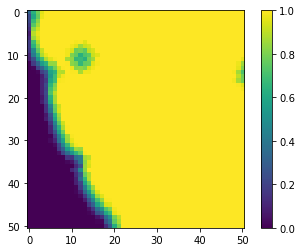

In [74]:
#load #/home/jingyi49/GliomaSolver/data/2D-complex/phi2D.mat
import scipy.io as sio
data_phi = sio.loadmat('/home/jingyi49/GliomaSolver/data/2D-complex/phi2D.mat')
phi = data_phi['phi']
#转为numpy array
phi = np.array(phi)
#reshape phi to [50,50]
phi=phi[130:181,30:81]
#plot phi
#plot phi in gray scale
plt.imshow(phi)
plt.colorbar()

In [75]:
#load data
path='/home/jingyi49/data/Fisher_2D_2Eq_Nonsymmetric.mat'
data=scipy.io.loadmat(path)
t = data['t'].flatten()[:,None]
x = data['x'][:,0].flatten()[:,None]
y = data['x'][:,1].flatten()[:,None]
#create a time/space grid
X, T = np.meshgrid(x,t)
Y, T = np.meshgrid(y,t)
#flatten X and T
xt = np.hstack((X.flatten()[:,None], T.flatten()[:,None])) #flatten X and T
yt = np.hstack((Y.flatten()[:,None], T.flatten()[:,None])) #flatten Y and T
xyt = np.array([xt[:,0], yt[:,0], xt[:,1]]).T # all (x,y,t) combos in an array (shape = (x*y*t, 3))
Exact_u=np.real(data['u1'])
Exact_u.shape

(51, 51, 501)

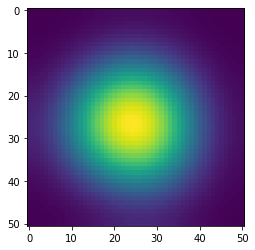

In [76]:
plt.imshow(Exact_u[:,:,-1])

In [77]:
u_star = np.array([])
for i in range(len(t)):
    u_star = np.append(u_star, Exact_u[:,:,i].T.flatten())
u_star = u_star.reshape(len(u_star),1) # values of the solution corresponding to the inputs of xyt

In [78]:
u_star.shape,xyt.shape #51*51*501

((1303101, 1), (1303101, 3))

In [79]:
#define the model structure
Inputs=tf.keras.Input(shape=(2,))#1D input
layer_number=100
Dense_1=tf.keras.layers.Dense(layer_number,activation='tanh',kernel_initializer="glorot_normal")(Inputs)
Dense_2=tf.keras.layers.Dense(layer_number,activation='tanh',kernel_initializer="glorot_normal")(Dense_1)
Dense_3=tf.keras.layers.Dense(layer_number,activation='tanh',kernel_initializer="glorot_normal")(Dense_2)
Dense_4=tf.keras.layers.Dense(layer_number,activation='tanh',kernel_initializer="glorot_normal")(Dense_3)
#output layer dimension is q
Predictions=tf.keras.layers.Dense(q)(Dense_4)
model_predict=tf.keras.Model(inputs=Inputs,outputs=Predictions)

In [80]:
#parameter for initial condition
IRK_weights=np.float32(np.loadtxt('/home/jingyi49/data/Butcher_IRK500.txt',ndmin=2))
IRK_times = IRK_weights[q**2+q:]
IRK_weights = IRK_weights[:q**2+q].reshape((q+1,q))
IRK_alpha = tf.constant(IRK_weights[:-1,:], dtype='float32')
IRK_beta = tf.constant(IRK_weights[-1:,:], dtype='float32')

In [81]:
xyt.shape

(1303101, 3)

In [82]:
#inputs = xyt[:int(np.sqrt(x.shape[0]))*int(np.sqrt(y.shape[0])),0:2]
inputs = xyt[:int(np.sqrt(x.shape[0]))*int(np.sqrt(y.shape[0])),0:2]
outputs_t0 = u_star[:int(np.sqrt(x.shape[0]))*int(np.sqrt(y.shape[0])),0] # Initial snapshot solution data
outputs_t1 = u_star[-int(np.sqrt(x.shape[0]))*int(np.sqrt(y.shape[0])):,0] # Final snapshot solution data
outputs_t0_noise = outputs_t0 + noise*np.std(outputs_t0)*np.random.randn(outputs_t0.shape[0]) # Initial snapshot solution data with noise
outputs_t1_noise = outputs_t1 + noise*np.std(outputs_t1)*np.random.randn(outputs_t1.shape[0]) # Final snapshot solution data with noise
dt=(t[-1]-t[0])[0]
#normalize the data
input_min=inputs.min(0)#minimum of each column
input_max=inputs.max(0)#maximum of each column
inputs_norm=2*(inputs-input_min)/(input_max-input_min)-1.0#normalize the inputs

#define tf,variables for neural network
inputs_var = tf.Variable(inputs_norm, name='inputs_var')
dummy=tf.ones((inputs_var.shape[0],q),dtype=np.float32)

In [83]:
#copy the phi to q times
phi=phi.reshape(inputs_var.shape[0],1)
#copy the phi m times using append
#phi=tf.concat([phi]*q,axis=1)
dummy.shape,phi.shape

(TensorShape([2601, 500]), (2601, 1))

In [84]:
phi_tf = tf.constant(phi, dtype=tf.float32)

In [88]:
##define solution of the PDE
class PDEsolution(tf.keras.layers.Layer):
    def __init__(self, D_var, r_var):
        super(PDEsolution, self).__init__()
        self.D_var = tf.Variable(np.array([D_var]))
        self.r_var = tf.Variable(np.array([r_var]))

    def loss(self,pred):   
        with tf.GradientTape(persistent=True) as tape:
                tape.watch(inputs_var)
                tape.watch(dummy)
                k = model_predict(inputs_var)
                g_U = tape.gradient(k, inputs_var, output_gradients=dummy) #U 关于x和y的导数
                g_U = tf.cast(g_U, dtype=tf.float32) 
                g_Ux = g_U[:,0]*phi_tf #U 关于x的导数 edit
                g_Uy = g_U[:,1]*phi_tf  #U 关于y的导数 edit
                k_x = tape.gradient(g_Ux, dummy)
                k_y = tape.gradient(g_Uy, dummy)
                
                g_Ux_U=tape.gradient(k_x,inputs_var,output_gradients=dummy) #Ux 关于x和y的导数
                g_Uy_U=tape.gradient(k_y,inputs_var,output_gradients=dummy) #Uy 关于x和y的导数
                g_UxUx = g_Ux_U[:,0] #Ux 关于x的导数
                g_UyUy = g_Uy_U[:,1] #Uy 关于y的导数
                k_xx = tape.gradient(g_UxUx, dummy) #U 关于x的二阶导数
                k_yy = tape.gradient(g_UyUy, dummy) #U 关于y的二阶导数
        scale_x = 2/(input_max[0]-input_min[0]) # Define scale factors and scale derivatives
        scale_y = 2/(input_max[1]-input_min[1]) # Define scale factors and scale derivatives,因为前面进行了归一化
        k_x = k_x*scale_x
        k_y = k_y*scale_y
        k_xx = k_xx*scale_x**2
        k_yy = k_yy*scale_y**2
        
    
    
        #implement the PDE
        D = tf.cast(tf.exp(self.D_var), tf.float32)
        r = tf.cast(tf.exp(self.r_var), tf.float32)
        u = k
        u_x = k_x
        u_y = k_y
        u_xx = k_xx
        u_yy = k_yy
        #change it to float32
        u_xx = tf.cast(u_xx, tf.float32)
        u_yy = tf.cast(u_yy, tf.float32)
        u= tf.cast(u, tf.float32)

        #u_t is float32 do not match the u_xx
        u_t_right = tf.cast(D*(u_xx+u_yy) + r*phi_tf*u*(1.0-u) , tf.float32)

        # condition for the initial condition
        dt = (t[-1] - t[0])[0] #total time
        U0_pred=k-dt*tf.matmul(u_t_right,tf.transpose(IRK_alpha)) #edit 
        U1_pred=k+dt*tf.matmul(u_t_right,tf.transpose(IRK_beta-IRK_alpha))  #plus
        # Format exact solutions for loss
        U0 = q*[outputs_t0_noise]
        U0 = tf.stack(U0, axis=1)   
        U0 = tf.cast(U0, tf.float32)
        U1 = q*[outputs_t1_noise]
        U1 = tf.stack(U1, axis=1)
        U1 = tf.cast(U1, tf.float32)

        # Calculate loss
        MSE = tf.reduce_mean(tf.square(U0*phi_tf - U0_pred)) + tf.reduce_mean(tf.square(U1*phi_tf - U1_pred))
        return MSE

    
    def call(self,pred):              #call the loss function
        self.add_loss(self.loss(pred))    #add loss to the model
        return pred       

In [89]:
D_guess = np.log(D)
r_guess = np.log(r)
My_loss=PDEsolution(D_guess,r_guess)(Predictions)
# Create trainable model with custom loss function

In [90]:
model_loss = tf.keras.Model(inputs=Inputs, outputs=My_loss)
model_loss.compile(optimizer=tf.keras.optimizers.Adam())
# Execute Adam optimization
inputs_var=tf.convert_to_tensor(inputs_var)
history=model_loss.fit(inputs_var,None, epochs=Adam_Epochs,verbose=0)  #None means no label

Text(0, 0.5, 'Loss')

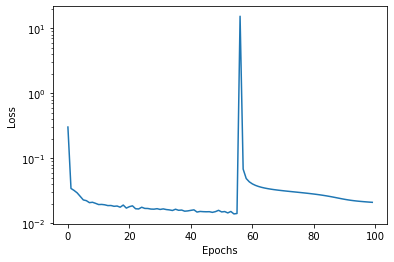

In [91]:
# Plot loss history
plt.figure()
plt.plot(history.history['loss'])
plt.yscale('log')
plt.xlabel('Epochs')
plt.ylabel('Loss')

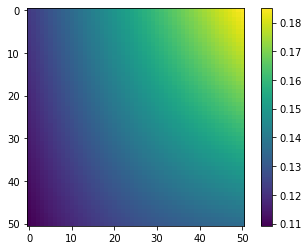

In [92]:
k_pred=model_predict(inputs_norm)
k_pred=k_pred.numpy().reshape(int(np.sqrt(x.shape[0])),int(np.sqrt(y.shape[0])),q)
plt.imshow(k_pred[:,:,-1])
plt.colorbar()

MovieWriter Pillow unavailable; using Pillow instead.


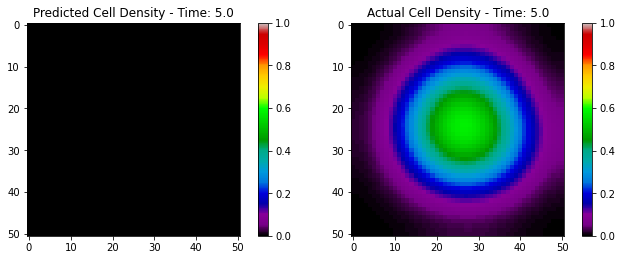

In [45]:
#plot the initial condition
k_pred=model_predict(inputs_norm)
k_pred=k_pred.numpy().reshape(int(np.sqrt(x.shape[0])),int(np.sqrt(y.shape[0])),q)
outputs_t0=outputs_t0.reshape(int(np.sqrt(x.shape[0])),int(np.sqrt(y.shape[0])),1)
outputs_t1=outputs_t1.reshape(int(np.sqrt(x.shape[0])),int(np.sqrt(y.shape[0])),1)
U_pred =np.dstack((outputs_t0, k_pred, outputs_t1))


# Create predicted and exact solutions with same time stepping for comparison
uniform_times = t
IRK_times = IRK_times*(t[-1]-t[0])+t[0]
num_plot_times = 2*q
dt_plot = dt/num_plot_times
t_plot = np.linspace(uniform_times[0], uniform_times[-1], num_plot_times)
Exact_plot = np.zeros((Exact_u.shape[0], Exact_u.shape[1], num_plot_times))
U_pred_plot = np.zeros((U_pred.shape[0], U_pred.shape[1], num_plot_times))

# FILEPATH: /Users/jinyili/Downloads/DR_2D.ipynb
for t in range(num_plot_times-1):
    i = 0
    while uniform_times[i] < t_plot[t][0]:
        i = i + 1
    j = 0
    while IRK_times[j] < t_plot[t][0]:
          j = j + 1
    Exact_plot[:,:,t] = Exact_u[:,:,i]
    U_pred_plot[:,:,t] = U_pred[:,:,j]
Exact_plot[:,:,-1] = Exact_u[:,:,-1]

# Create animation
fig, axs = plt.subplots(1, 2, constrained_layout=True)
fig.set_figheight(3.5)
fig.set_figwidth(9)

CS1 = axs[0].imshow(U_pred_plot[:,:,0], vmin = 0.0, vmax = 1.0, cmap=cm.nipy_spectral)
fig.colorbar(CS1, ax=axs[0])

CS2 = axs[1].imshow(Exact_plot[:,:,0].T, vmin = 0.0, vmax = 1.0, cmap=cm.nipy_spectral)
fig.colorbar(CS2, ax=axs[1])

def animate(i):

        axs[0].clear()
        axs[0].imshow(U_pred_plot[:,:,i], vmin = 0.0, vmax = 1.0, cmap=cm.nipy_spectral)
        axs[0].set_title("Predicted Cell Density - Time: " + str(round(t_plot[i][0],2)))

        axs[1].clear()
        axs[1].imshow(Exact_plot[:,:,i].T, vmin = 0.0, vmax = 1.0, cmap=cm.nipy_spectral)
        axs[1].set_title("Actual Cell Density - Time: " + str(round(t_plot[i][0],2)))
interval = 1e+3*0.01 # 2nd number is the seconds
ani = animation.FuncAnimation(fig, animate, num_plot_times, interval=interval, blit=False)
ani.save('Fisher_2D_2Eq_Nonsymmetric.gif', writer='Pillow', fps=1)
plt.show()